In [1]:
## importing necessary dependies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from obspy.geodetics.base import gps2dist_azimuth

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


from obspy.clients.fdsn import Client
client = Client("IRIS")

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from functools import reduce

#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time
#import pygmt
import matplotlib
import random

from math import radians, sin, cos, sqrt, atan2

In [2]:
# reading the icequakes catalog
icequakes = pd.read_csv('../Catalogs/icequakes_catalog.csv')

# reading the earthquake catalog
earthquakes = pd.read_csv('../Catalogs/earthquakes_catalog.csv')

# reading the stations catalog. 
stations = pd.read_csv('../Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])

In [3]:
# Function to calculate Haversine distance
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

icequake_coords = icequakes[['latitude', 'longitude']].values
earthquake_coords = earthquakes[['latitude', 'longitude']].values

dist_mat = haversine_vectorized(icequake_coords[:, 0, np.newaxis], icequake_coords[:, 1, np.newaxis], 
                                earthquake_coords[:, 0], earthquake_coords[:, 1])

# Optionally, you can use tqdm here if needed
# for i in tqdm(range(len(icequakes))):
#     dist_mat[i, :] = haversine_vectorized(icequake_coords[i, 0], icequake_coords[i, 1],
#                                           earthquake_coords[:, 0], earthquake_coords[:, 1])


In [4]:
dist_mat.shape

(2649, 12282)

In [5]:
import numpy as np

def find_minimum_index(matrix):
    # Convert the matrix to a NumPy array for better performance
    matrix = np.array(matrix)

    # Find the indices of the minimum value using np.unravel_index
    min_index = np.unravel_index(np.argmin(matrix), matrix.shape)

    return min_index


In [6]:
find_minimum_index(dist_mat)

(1235, 9006)

In [7]:
dist_mat[1235, 9006]

0.012347750544996238

In [8]:
np.argsort(dist_mat, axis = 0)

array([[  65, 1207, 2449, ...,  765,  765,  765],
       [ 125, 2157, 2266, ..., 2595, 2595, 2595],
       [ 491,  458, 2454, ..., 2450, 2450, 2450],
       ..., 
       [1320, 1320, 2527, ..., 1700, 1700, 1700],
       [ 150,  150, 1700, ..., 2527, 2527, 2527],
       [ 670,  670,  317, ...,  317,  317,  317]])

In [9]:
dist_mat[65,0]

0.048006016520970016

In [10]:
iq_id = 2262
eq_id = 740
X_iq = []
X_eq = []
t_iq = []
t_eq = []

stn_new = ['SAW']
dur = 1
for i in range(1):
    st_iq = obspy.read('../Data/icequake_waveforms/icequake'+str(iq_id)+'_'+stn_new[i]+'.mseed').select(channel='BHZ')[0]
    
    network = st_iq.stats.network
    station = st_iq.stats.station
    location = st_iq.stats.location
    channel = st_iq.stats.channel
    starttime = st_iq.stats.starttime
    endtime = st_iq.stats.endtime
    inv = client.get_stations(network = network, station= station, location= location, channel=channel,
             starttime=starttime, endtime=endtime, level="response")

    st_iq.remove_response(inventory= inv, output = "VEL")
    
    st_iq.taper(0.1)
    st_iq.filter('bandpass', freqmin= 1, freqmax=10)
    
    X_iq.append(np.abs(np.fft.fft(st_iq.data[0:int(dur*60*50)]))/np.max(np.abs(np.fft.fft(st_iq.data[0:int(dur*60*50)])))) 
    t_iq.append(st_iq)
    
    
    
    st_eq = obspy.read('../Data/earthquake_waveforms/earthquake_'+str(eq_id)+'_'+stn_new[i]+'.mseed').select(channel='BHZ')[0]
    network = st_eq.stats.network
    station = st_eq.stats.station
    location = st_eq.stats.location
    channel = st_eq.stats.channel
    starttime = st_eq.stats.starttime
    endtime = st_eq.stats.endtime
    inv = client.get_stations(network = network, station= station, location= location, channel=channel,
             starttime=starttime, endtime=endtime, level="response")

    st_eq.remove_response(inventory= inv, output = "VEL")
    st_eq.taper(0.1)
    st_eq.filter('bandpass', freqmin= 1, freqmax=10)
    t_eq.append(st_eq)
    X_eq.append(np.abs(np.fft.fft(st_eq.data[0:int(dur*60*50)]))/np.max(np.abs(np.fft.fft(st_eq.data[0:int(dur*60*50)]))))  
    
    
val = pd.read_csv('../Catalogs/icequakes_catalog.csv').values[iq_id]
time_iq, lat_iq, lon_iq, depth_iq, mag_iq  = val[0], val[1], val[2], val[3], val[4]

val = pd.read_csv('../Catalogs/earthquakes_catalog.csv').values[eq_id]
time_eq, lat_eq, lon_eq, depth_eq, mag_eq  = val[0], val[1], val[2], val[3], val[4]

In [15]:
ax.flat

/tmp/ipykernel_1497627/825689884.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


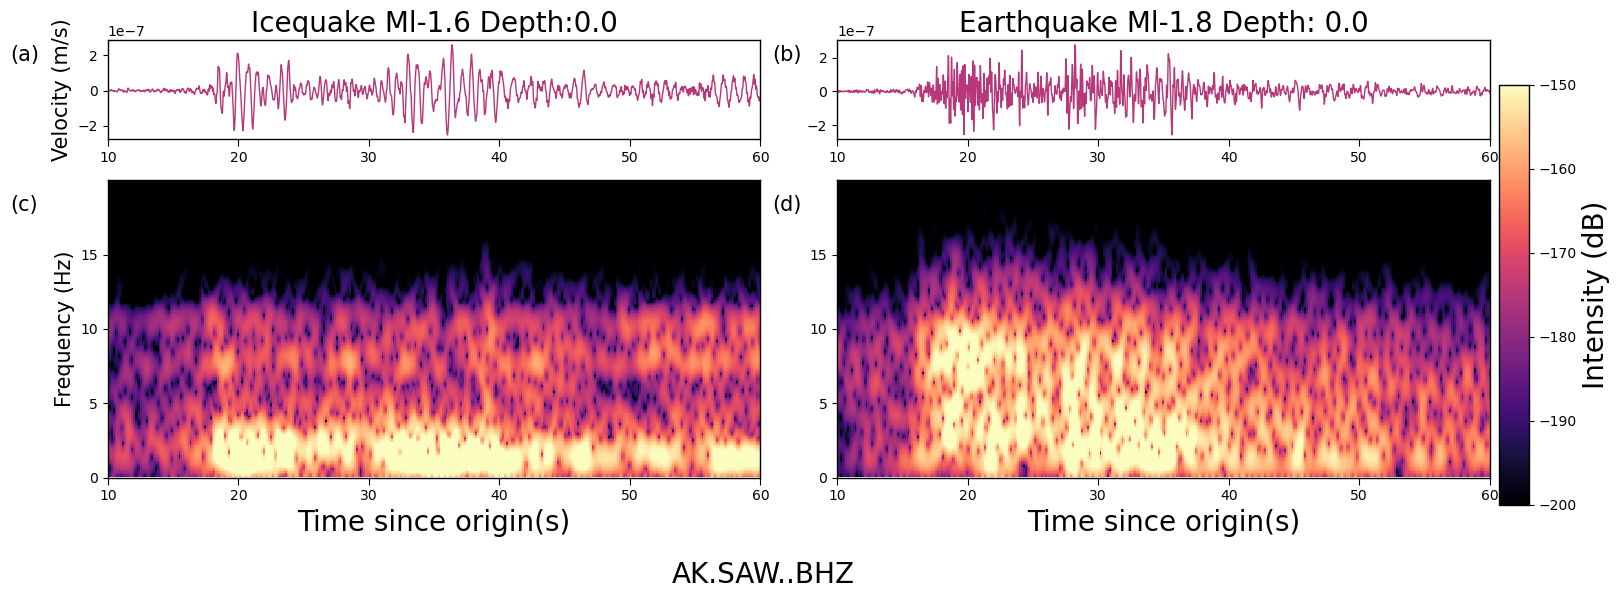

In [35]:
l1 = 0
l2 = 20

# Assuming you have imported necessary libraries and defined variables like t_iq, t_eq, mag_iq, mag_eq, depth_iq, depth_eq, c3, l1, l2

plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 5



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [1, 1]})


cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)



# Add labels to subplots
labels = ['(a)', '(b)', '(c)', '(d)']
xorients = [-0.15, -0.1,-0.15,-0.1]



for i, axi in enumerate(ax.flat):
    axi.text(xorients[i], 0.95, labels[i], transform=axi.transAxes,
            fontsize=15, va='top')
    


time = t_iq[0].times()

# Plot for Icequake
ax[0, 0].plot(time, t_iq[0].data, lw=1, color=c3)
ax[0, 0].set_xlim(10, 60)
ax[0, 0].set_ylabel('Velocity (m/s)', fontsize = 15)
ax[1, 0].set_ylabel('Frequency (Hz)', fontsize = 15)
ax[0, 0].set_title('Icequake' + ' Ml-' + str(mag_iq) + ' Depth:' + str(depth_iq), fontsize=20)
yax_iq = t_iq[0].spectrogram(show=False, wlen=1, dbscale=True, cmap='magma', axes=ax[1, 0])
ax[1, 0].set_xlim(10, 60)
ax[1, 0].set_yticks(np.arange(0, 20, 5))
ax[1, 0].set_ylim(l1, l2)
ax[1, 0].set_xlabel('Time since origin(s)', fontsize=20)
im_iq = yax_iq.images[0]
im_iq.set_clim(vmin=-200, vmax=-150)

# Plot for Earthquake
ax[0, 1].plot(time, t_eq[0].data, lw=1, color=c3)
ax[0, 1].set_xlim(10, 60)
ax[0, 1].set_title('Earthquake' + ' Ml-' + str(mag_eq) + ' Depth: ' + str(depth_eq), fontsize=20)
yax_eq = t_eq[0].spectrogram(show=False, wlen=1, dbscale=True, cmap='magma', axes=ax[1, 1])
ax[1, 1].set_xlim(10, 60)
ax[1, 1].set_ylim(l1, l2)
ax[1, 1].set_yticks(np.arange(0, 20, 5))
ax[1, 1].set_xlabel('Time since origin(s)', fontsize=20)
im_eq = yax_eq.images[0]
im_eq.set_clim(vmin=-200, vmax=-150)

# Create a new axis for the common colorbar
cax = fig.add_axes([0.99, 0.15, 0.02, 0.7])  # Adjust the values based on your layout
cbar = plt.colorbar(im_eq, cax=cax)
cbar.set_label('Intensity (dB)', fontsize=20)

fig.supxlabel(t_eq[0].id, fontsize=20)
plt.tight_layout()

plt.show()
